In [1]:
# Import z3
from z3 import *

#### Chessboard Setup and Constraints for N-Queens Problem
In this segment, we define the foundational elements of the N-Queens problem:
- **Chessboard Size (N)**: Set to 8, representing an 8x8 chessboard.
- **Queen Position Mapping (Q_map)**: A dictionary mapping each Queen's position to a unique Bit Vector, a format suitable for constraint programming.
- **Reverse Mapping (queen_to_col)**: Converts Bit Vectors back to their corresponding positions, facilitating easy access to Queen positions.
- **Value Constraints (val_c)**: Ensures that each Queen is placed within the valid range of the chessboard.
- **Diagonal Constraints (diag_c)**: Utilizes the `Distinct` function to enforce that no two Queens share the same diagonal, a critical rule in the N-Queens problem.

In [2]:
# Define the size of the chessboard (N x N)
N = 8

# Create a mapping of Queen positions using Bit Vectors for constraint satisfaction
Q_map = {BitVecVal(i+1,16): BitVec('Q_%i' % (i + 1),16) for i in range(N)}

# Reverse mapping from Queen Bit Vectors to their positions
queen_to_col = {v: k for k, v in Q_map.items()}

# Constraints ensuring that Queen values are within the chessboard range
val_c = [And(1 <= Q_map[BitVecVal(i+1,16)], Q_map[BitVecVal(i+1,16)] <= N) for i in range(N)]

# Constraints for distinct Queen positions on the diagonal
diag_c = Distinct([Q_map[BitVecVal(i+1,16)] for i in range(N)]) 

#### CQueenPropagator Class for Constraint Propagation
The `QueenPropagator` class extends `UserPropagateBase` to solve the N-Queens problem:
- **Initialization**: Sets up necessary data structures for backtracking (`trail`, `lim`) and mappings for Queen positions.
- **Methods**:
  - **push**: Saves the current state for potential backtracking.
  - **pop**: Reverts the solver's state by undoing actions, illustrating backtracking capability.
  - **_fixed** and **_fixed_trail**: Manage the assignment of Queens and update the trail for backtracking, including conflict checks.
  - **_final**: Signifies the completion of the solution process.
  - **check_conflict**: Ensures no two Queens threaten each other, checking for conflicts in rows, columns, and diagonals.

In [3]:
class QueenPropagator(UserPropagateBase):
    def __init__(self, s=None, ctx=None):
        UserPropagateBase.__init__(self, s, ctx)
        self.trail = []         # Trail for storing undo actions
        self.lim = []           # Limit for the trail stack
        self.add_fixed(lambda x, v: self._fixed(x, v))  # Handler for fixed queens
        self.add_final(lambda: self._final())           # Handler for final state

        self._fixed_le = []     # List of fixed queens and their values
        self.Q_map = Q_map      # Mapping from Bit Vectors to queen positions
        self.queen_to_col = queen_to_col  # Mapping from queens to columns
        for k, v in Q_map.items():
            self.add(v)        # Register all queens as variables

    def push(self):
        # Save the current state of the solver for backtracking
        self.lim += [len(self.trail)]

    def pop(self, n):
        # Revert 'n' states back in the solver's history
        print("POP")
        head = self.lim[len(self.lim) - n]
        while len(self.trail) > head:
            self.trail[-1]()    # Undo the last action
            self.trail.pop(-1)  # Remove the action from the trail
        self.lim = self.lim[0:len(self.lim)-n]
    
    def _fixed(self, x, v):        
        # Handle a queen being fixed to a specific position
        print("fixed: ", x, " := ", v)
        self._fixed_trail(x, v, self._fixed_le)
       
    def _fixed_trail(self, x, v, trail):
        # Check for conflicts and add the fixed queen to the trail
        if self.check_conflict(x, v):
            return
        trail.append((x, v))
        def undo():
            trail.pop(-1)   # Define an undo function for backtracking
        self.trail.append(undo)
        
    def _final(self):
        # Handle the final state of the solver
        print("Final")
        
    def check_conflict(self, current_queen, queen_row):
        # Check if the current queen's placement conflicts with others
        print(self._fixed_le)
        queen_column = self.queen_to_col[current_queen]
        queen_column = int(queen_column.as_long())
        queen_row = int(queen_row.as_long())

        for fixed_queen in self._fixed_le:
            other_queen = fixed_queen[0]
            other_queen_column = self.queen_to_col[other_queen]
            other_queen_row = fixed_queen[1]

            other_queen_column = int(other_queen_column.as_long())
            other_queen_row = int(other_queen_row.as_long())

            # Check for same column or same row conflict
            if other_queen_column == queen_column or other_queen_row == queen_row:
                print("Invalid")
                return True
            
            # Check for diagonal conflict
            diff_row = abs(other_queen_row - queen_row)
            diff_col = abs(other_queen_column - queen_column)
            if diff_col == diff_row:
                print("DIAGONAL INVALID")
                self.conflict(deps=[current_queen, other_queen])                
                return True
            
        return False


In [4]:
# Instantiate a Solver and QueenPropagator, add constraints, and check for solutions
s = Solver()
qp = QueenPropagator(s)
s.add(diag_c)
s.add(val_c)
s.check()

fixed:  Q_7  :=  2
[]
fixed:  Q_8  :=  6
[(Q_7, 2)]
fixed:  Q_6  :=  1
[(Q_7, 2), (Q_8, 6)]
DIAGONAL INVALID
POP
fixed:  Q_6  :=  3
[(Q_7, 2), (Q_8, 6)]
DIAGONAL INVALID
POP
fixed:  Q_7  :=  6
[]
fixed:  Q_8  :=  2
[(Q_7, 6)]
fixed:  Q_6  :=  1
[(Q_7, 6), (Q_8, 2)]
fixed:  Q_1  :=  8
[(Q_7, 6), (Q_8, 2), (Q_6, 1)]
fixed:  Q_2  :=  4
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8)]
fixed:  Q_3  :=  3
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8), (Q_2, 4)]
DIAGONAL INVALID
POP
fixed:  Q_3  :=  7
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8), (Q_2, 4)]
DIAGONAL INVALID
POP
fixed:  Q_3  :=  5
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8), (Q_2, 4)]
DIAGONAL INVALID
POP
POP
fixed:  Q_2  :=  5
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8)]
DIAGONAL INVALID
POP
fixed:  Q_2  :=  3
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8)]
fixed:  Q_3  :=  4
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8), (Q_2, 3)]
DIAGONAL INVALID
POP
fixed:  Q_3  :=  5
[(Q_7, 6), (Q_8, 2), (Q_6, 1), (Q_1, 8), (Q_2, 3)]
fixed:  Q_4  :=  7
[(Q_7, 6), (Q_8, 2), (Q_6,

sat

#### Performance Evaluation for Various Chessboard Sizes
This cell conducts a performance evaluation of the N-Queens solver:
- A loop iterates over chessboard sizes from 6 to 19.
- For each size, the relevant mappings and constraints are redefined, and a new instance of `Solver` and `QueenPropagator` is created.
- The time taken to check for a solution is measured, providing insight into the solver's performance across different problem sizes. This analysis is crucial for understanding the scalability and efficiency of the constraint-solving approach in the N-Queens problem.

In [5]:
# Performance testing for various N values (6 to 19)
import time
times = []
for i in range(6, 20):
    N = i  # Update the size of the chessboard

    # Recreate mappings and constraints for the new size
    Q_map = {BitVecVal(i+1,16): BitVec('Q_%i' % (i + 1),16) for i in range(N)}
    queen_to_col = {v: k for k, v in Q_map.items()}
    val_c = [And(1 <= Q_map[BitVecVal(i+1,16)], Q_map[BitVecVal(i+1,16)] <= N) for i in range(N)]
    diag_c = Distinct([Q_map[BitVecVal(i+1,16)] for i in range(N)]) 

    # Instantiate and add constraints for the new problem size
    s = Solver()
    qp = QueenPropagator(s)
    s.add(diag_c)
    s.add(val_c)

    # Measure the time taken to check for a solution
    time1 = time.time()
    s.check()
    time2 = time.time()
    times.append(time2-time1)


fixed:  Q_6  :=  3
[]
fixed:  Q_5  :=  2
[(Q_6, 3)]
DIAGONAL INVALID
POP
fixed:  Q_5  :=  1
[(Q_6, 3)]
POP
fixed:  Q_5  :=  1
[(Q_6, 3)]
fixed:  Q_4  :=  4
[(Q_6, 3), (Q_5, 1)]
POP
fixed:  Q_5  :=  1
[(Q_6, 3)]
fixed:  Q_4  :=  4
[(Q_6, 3), (Q_5, 1)]
fixed:  Q_3  :=  2
[(Q_6, 3), (Q_5, 1), (Q_4, 4)]
POP
fixed:  Q_5  :=  1
[(Q_6, 3)]
fixed:  Q_3  :=  2
[(Q_6, 3), (Q_5, 1)]
fixed:  Q_4  :=  4
[(Q_6, 3), (Q_5, 1), (Q_3, 2)]
fixed:  Q_2  :=  5
[(Q_6, 3), (Q_5, 1), (Q_3, 2), (Q_4, 4)]
POP
fixed:  Q_5  :=  1
[(Q_6, 3)]
fixed:  Q_2  :=  5
[(Q_6, 3), (Q_5, 1)]
fixed:  Q_4  :=  4
[(Q_6, 3), (Q_5, 1), (Q_2, 5)]
fixed:  Q_3  :=  2
[(Q_6, 3), (Q_5, 1), (Q_2, 5), (Q_4, 4)]
fixed:  Q_1  :=  6
[(Q_6, 3), (Q_5, 1), (Q_2, 5), (Q_4, 4), (Q_3, 2)]
DIAGONAL INVALID
POP
fixed:  Q_1  :=  2
[(Q_6, 3), (Q_5, 1), (Q_2, 5), (Q_4, 4)]
fixed:  Q_3  :=  6
[(Q_6, 3), (Q_5, 1), (Q_2, 5), (Q_4, 4), (Q_1, 2)]
DIAGONAL INVALID
POP
fixed:  Q_1  :=  2
[(Q_6, 3), (Q_5, 1), (Q_2, 5), (Q_4, 4)]
POP
POP
fixed:  Q_2  :=  4
[(

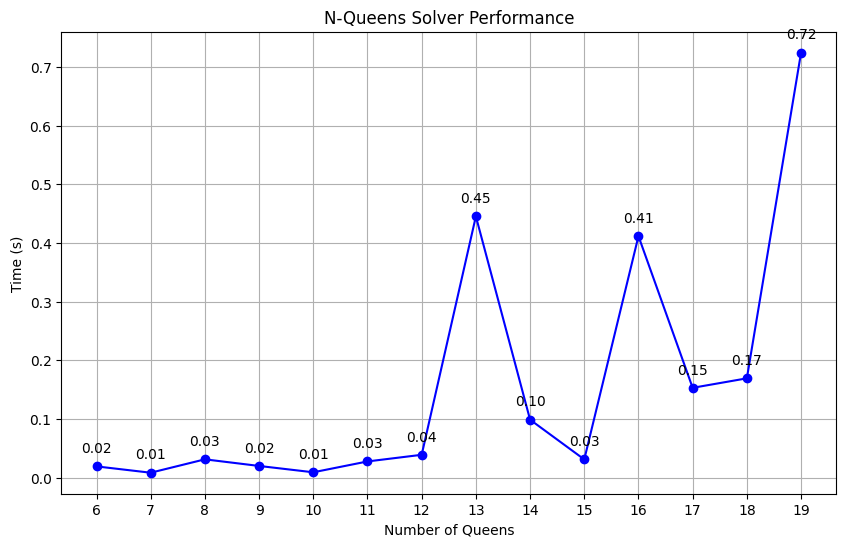

In [6]:
import matplotlib.pyplot as plt

# Improved visualization of the run times
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(range(6, 20), times, marker='o', linestyle='-', color='b')  # Add markers for each data point

plt.title('N-Queens Solver Performance')  # Add a title to the plot
plt.ylabel('Time (s)')  # Label for Y-axis
plt.xlabel('Number of Queens')  # Label for X-axis
plt.xticks(range(6, 20))  # Set x-ticks to clearly show the number of queens
plt.grid(True)  # Enable grid for easier readability

# Optional: Add annotations for specific points
for i, txt in enumerate(times):
    plt.annotate(f"{txt:.2f}", (range(6, 20)[i], times[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()  # Display the plot